# Práctica 1 de aprendizaje automático
### Autor: Juan Francisco Sánchez García y wordsavier Matas Perelló
<br>
El objetivo de esta práctica es encontrar un modelo que sea capaz de identificar el idioma de una palabra dada. En una primera instancia de esta práctica se resolverá para el idioma catalán e inglés

In [40]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC, SVR
import pandas as pd
from sklearn.decomposition import PCA
import csv
import json

# Declaración de funciones
def do_svm_hyper_parameters(X,y):
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Normalización de los datos
    scaler = StandardScaler()
    X_transformed = scaler.fit_transform(X_train)
    X_test_transformed = scaler.transform(X_test)

    # Configuración más óptima de los hiperparámetros
    inner_kfold = KFold(n_splits=3)
    model = SVC() # modelo
    space = dict()
    space['C'] = [0.1, 1, 10, 100]
    space['gamma'] = [1, 0.1, 0.01, 0.001]
    space['kernel'] = ['rbf', 'linear'] # parametros para configurar el SVM
    outer_kfold = KFold(n_splits=10)
    outer_result = []
    models = []
    for train_ix, test_ix in outer_kfold.split(X_transformed):
        #separar en conjunto de entrenamiento y test para cada fold
        X_transformed_train, X_transformed_test = X_transformed[train_ix, :], X_transformed[test_ix, :]
        y_train_kfold, y_test_kfold = y_train[train_ix], y_train[test_ix]
        #definir los parámetros del gridsearch
        grid = GridSearchCV(model, space, scoring='accuracy', cv=inner_kfold, refit=True)
        #ejecución del gridsearch
        result = grid.fit(X_transformed_train, y_train_kfold)
        best_model = result.best_estimator_
        best_params = result.best_params_
        y_predicted_kfold = best_model.predict(X_transformed_test)
        # evaluación del modelo
        differences = (y_predicted_kfold - y_test_kfold)
        errors = np.count_nonzero(differences)
        # store the result
        precision = (len(y_predicted_kfold)-errors)/len(y_predicted_kfold)
        outer_result.append(precision)
        models.append({'precision': precision, 'model': best_params})
        # report progress
        print('>acc=%.3f, est=%.3f, cfg=%s' % (precision, result.best_score_, result.best_params_))
    # resumen del rendimiento del modelo
    print('Precision: %.3f (%.3f)' % (np.mean(outer_result), np.std(outer_result)))
    
    # Entrenar el mejor modelo con todo el conjunto de entrenamiento y testear
    svm = SVC(**find_best_params(models)) # desempaquetar los parametros
    svm.fit(X_transformed, y_train)
    y_predicted = svm.predict(X_test_transformed)
    differences = (y_predicted - y_test)
    errors = np.count_nonzero(differences)
    print(f'Ratio de aciertos en el bloque de predicción: {(len(y_predicted)-errors)/len(y_predicted)}')
    print(f'F1-Score: {f1_score(y_test, y_predicted, average=None)}')
    print(f'Precision: {precision_score(y_test, y_predicted, average=None)}')
    print(f'Recall: {recall_score(y_test, y_predicted, average=None)}')
    plot_confusion_matrix(svm, X_test_transformed, y_test)

def do_svm_kfolding(X,y):
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Normalización de los datos
    scaler = StandardScaler()
    X_transformed = scaler.fit_transform(X_train)
    X_test_transformed = scaler.transform(X_test)

    model = SVC(C=1.0, kernel='rbf') # modelo

    #cross val score
    print(cross_val_score(model, X_transformed, y_train, cv=10))
    model.fit(X_transformed, y_train)
    y_predicted = model.predict(X_test_transformed)
    differences = (y_predicted - y_test)
    errors = np.count_nonzero(differences)
    print(f'Ratio de aciertos en el bloque de predicción: {(len(y_predicted)-errors)/len(y_predicted)}')
    print(f'F1-Score: {f1_score(y_test, y_predicted, average=None)}')
    print(f'Precision: {precision_score(y_test, y_predicted, average=None)}')
    print(f'Recall: {recall_score(y_test, y_predicted, average=None)}')
    plot_confusion_matrix(model, X_test_transformed, y_test)

# función para encontrar los mejores parámetros del modelo
def find_best_params(models):
    model_aux = {'precision': 0}
    for model in models:
        if model['precision'] > model_aux['precision']:
            model_aux = model
    return model_aux['model']

#plot matriz de confusión
def plot_confusion_matrix(svm, X, y):
    np.set_printoptions(precision=2)

    # Plot confusion matrix
    titles_options = [
        ("Matriz de confusión", None),
        ("Matriz de confusión normalizada", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            svm,
            X,
            y,
            display_labels=['catalán', 'inglés', 'alemán', 'italiano'],
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
    
    plt.show()


In [41]:
##Carga de los datos
words = []
y = []

with open('data/data.csv', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    an = ""
    cat = ""
    dtsc = ""
    it = ""
    for row in csv_reader:
        row[1] = row[1].lower()
        row[2] = row[2].lower()
        if(row[1] != row[2]):
            if i == 0:
                cat = row[1]
                an = row[2]
                dtsc = row[3]
                it = row[4]
            else:
                words.append(row[1])
                y.append(cat)
                words.append(row[2])
                y.append(an)
                words.append(row[3])
                y.append(dtsc)
                words.append(row[4])
                y.append(it)
            i += 1

for xy in zip(words, y):
    print(xy)

('com', 'catala')
('as', 'angles')
('als', 'Deutsche')
('come', 'italiano')
('seva', 'catala')
('his', 'angles')
('seine', 'Deutsche')
('sua', 'italiano')
('que', 'catala')
('that', 'angles')
('das', 'Deutsche')
('Quello', 'italiano')
('ell', 'catala')
('he', 'angles')
('er', 'Deutsche')
('lui', 'italiano')
('era', 'catala')
('was', 'angles')
('war', 'Deutsche')
('era', 'italiano')
('per', 'catala')
('for', 'angles')
('Pro', 'Deutsche')
('per', 'italiano')
('en', 'catala')
('on', 'angles')
('an', 'Deutsche')
('Su', 'italiano')
('són', 'catala')
('are', 'angles')
('sind', 'Deutsche')
('sono', 'italiano')
('amb', 'catala')
('with', 'angles')
('mit', 'Deutsche')
('con', 'italiano')
('ells', 'catala')
('they', 'angles')
('sie', 'Deutsche')
('essi', 'italiano')
('ser', 'catala')
('be', 'angles')
('sein', 'Deutsche')
('essere', 'italiano')
('en', 'catala')
('at', 'angles')
('bei', 'Deutsche')
('in', 'italiano')
('un', 'catala')
('one', 'angles')
('einer', 'Deutsche')
('uno', 'italiano')
('te

<p>Una vez ya se ha cargado el csv y separado el conjunto de los datos con el de las salidas, podemos tratar los datos para conseguir las mejores caracteristicas posibles.</p>

In [42]:
#tratamiento del vector de entrada
map = {}
print(len(words)/2)
for word in words:
    aux = word
    for char in aux:
        if(char in map.keys()):
            map[char] += 1
        else:
            map[char] = 1

#mostrar que los resultados estan guay
for key in map.keys():
    print(key + " " + str(map[key]))


1874.0
c 926
o 1455
m 536
a 1990
s 1183
l 1057
e 2782
v 270
h 495
i 1493
n 1416
u 663
q 56
t 1465
d 583
Q 3
r 1855
w 158
p 574
f 313
P 29
S 90
ó 26
b 321
y 96
ß 15
W 27
ò 13
è 13
g 514
é 14
D 14
z 120
k 129
A 28
Z 12
à 45
j 37
ä 31
L 23
G 32
E 25
H 17
F 39
I 7
í 16
x 45
C 11
M 40
R 22
ü 42
B 37
V 10
T 18
N 17
O 10
J 5
ú 6
Ü 3
ö 18
ì 3
ù 2
K 30
' 1
ç 12
· 1
Ä 1
- 2
U 7
Ö 1


A partir de los caracteres que se usan en los idiomas, sacamos las permutaciones posibles y contamos las apariciones de estas permutaciones. Esto es para posteriormente aplicar un PCA a las características y borrar la gran mayoria de ellas.

In [43]:
#obtener el array con todas las sílabas posibles.
caracteres = list(map.keys())
print(caracteres)
silabas = []
while len(caracteres) > 0:
    char_to_permute = caracteres.pop(0)
    silabas.append(char_to_permute)
    for c in caracteres:
        silabas.append(char_to_permute + c)

print(silabas)
print(len(silabas))

['c', 'o', 'm', 'a', 's', 'l', 'e', 'v', 'h', 'i', 'n', 'u', 'q', 't', 'd', 'Q', 'r', 'w', 'p', 'f', 'P', 'S', 'ó', 'b', 'y', 'ß', 'W', 'ò', 'è', 'g', 'é', 'D', 'z', 'k', 'A', 'Z', 'à', 'j', 'ä', 'L', 'G', 'E', 'H', 'F', 'I', 'í', 'x', 'C', 'M', 'R', 'ü', 'B', 'V', 'T', 'N', 'O', 'J', 'ú', 'Ü', 'ö', 'ì', 'ù', 'K', "'", 'ç', '·', 'Ä', '-', 'U', 'Ö']
['c', 'co', 'cm', 'ca', 'cs', 'cl', 'ce', 'cv', 'ch', 'ci', 'cn', 'cu', 'cq', 'ct', 'cd', 'cQ', 'cr', 'cw', 'cp', 'cf', 'cP', 'cS', 'có', 'cb', 'cy', 'cß', 'cW', 'cò', 'cè', 'cg', 'cé', 'cD', 'cz', 'ck', 'cA', 'cZ', 'cà', 'cj', 'cä', 'cL', 'cG', 'cE', 'cH', 'cF', 'cI', 'cí', 'cx', 'cC', 'cM', 'cR', 'cü', 'cB', 'cV', 'cT', 'cN', 'cO', 'cJ', 'cú', 'cÜ', 'cö', 'cì', 'cù', 'cK', "c'", 'cç', 'c·', 'cÄ', 'c-', 'cU', 'cÖ', 'o', 'om', 'oa', 'os', 'ol', 'oe', 'ov', 'oh', 'oi', 'on', 'ou', 'oq', 'ot', 'od', 'oQ', 'or', 'ow', 'op', 'of', 'oP', 'oS', 'oó', 'ob', 'oy', 'oß', 'oW', 'oò', 'oè', 'og', 'oé', 'oD', 'oz', 'ok', 'oA', 'oZ', 'oà', 'oj', 'oä', 'o

En vista de que hay números hemos decido ver que registros son y hemos encontrado un registro con 2:00 y two. Hemos transformado el 2:00 a "dos". Con la obtención de las combinaciones de caracteres podemos continuar con la limpieza de los datos. En este caso aquellas combinaciones que aparezcan en ambos idiomas o no aparezcan las podemos eliminar.

In [44]:
#funcion que comprueba si una silaba se encuentra en las palabras
def in_words(s, words):
    for w in words:
        if w.find(s) != -1:
            return True
    return False
 
#filtrado de las combinaciones
silabas = [s for s in silabas if in_words(s, words)]
print(len(silabas))
languages = ["angles", "catala", "Deutsche", "italiano"]

#funcion que encuentra si una silaba está en un lenguaje
def in_language(s, words, y, language):
    eslanguage = len([y for x,y in zip(words, y) if x.find(s) != -1 and y == language]) > 0
    if eslanguage:
        return True

#función que encuentra si una sílaba es de un único lenguaje
def in_one_language(s, words, y, language):
    eslanguage = len([y for x,y in zip(words, y) if x.find(s) != -1 and y == language]) > 0
    esotros = len([y for x,y in zip(words, y) if x.find(s) != -1 and y != language]) > 0
    if eslanguage and not esotros:
        return True

#filtrado de las silabas por idioma
sil_per_language = []
for l in languages:
    sil_per_language.append([s for s in silabas if in_language(s, words, y, l)])

#filtrado de las silabas especiales de un idioma
sil_per_one_language = []
for l in languages:
    sil_per_one_language.append([s for s in silabas if in_one_language(s, words, y, l)])
print(sil_per_one_language)

#filtrado de los caracteres especiales de un idioma
char_per_one_language = []
for l in languages:
    char_per_one_language.append([s for s in silabas if in_one_language(s, words, y, l) and len(s) == 1])
print(char_per_one_language)


374
[['oa', 'oy', 'my', 'aw', 'ay', 'sl', 'sh', 'sn', 'sw', 'sy', 'lw', 'ly', 'ey', 'vy', "n'", 'uy', 'dy', 'dg', 'ry', 'py', 'yg', "'"], ['cs', 'có', 'cò', 'cé', 'ms', 'mr', 'mó', 'mè', 'mé', 'mà', 'mí', 'mú', 'aq', 'aó', 'aí', 'aç', 'sd', 'só', 'sò', 'sí', 'lò', 'lè', 'lí', 'l·', 'eà', 'ej', 'eí', 'eç', 'vé', 'ví', 'ió', 'iè', 'iç', 'nj', 'nú', 'nç', 'uè', 'uj', 'uí', 'qü', 'td', 'tó', 'tò', 'tè', 'tg', 'té', 'tj', 'tx', 'dó', 'dò', 'dí', 'dú', 'ró', 'rò', 'rè', 'ré', 'rà', 'rí', 'rç', 'pè', 'fí', 'ó', 'bé', 'bà', 'èx', 'gü', 'í', 'ú', 'ç', '·'], ['oh', 'oß', 'ml', 'mh', 'mt', 'mw', 'mö', 'ah', 'aß', 'sr', 'sz', 'sä', 'sü', 'ln', 'lä', 'lü', 'lö', 'eß', 'vö', 'hn', 'hw', 'hä', 'hü', 'hö', 'iß', 'nr', 'nw', 'nä', 'nü', 'nö', 'uß', 'uk', 'tä', 'tü', 'tö', 'db', 'dü', 'rä', 'rü', 'rö', 'wä', 'wü', 'pf', 'pä', 'fz', 'fä', 'fü', 'Sy', 'Sk', 'Sä', 'Sü', 'ß', 'W', 'Wä', 'Wö', 'gz', 'gk', 'zä', 'kü', 'kö', 'Z', 'ä', 'Lü', 'Lö', 'H', 'Hü', 'Rü', 'J', 'Ü', 'ö', 'K', 'Ä', 'U', 'Ö'], ['cq', 'ae'

Una vez ya tenemos filtradas las sílabas por idioma podemos empezar a crear el vector de características, este en una primera instancia estará formado por si la palabra contiene una silaba caracteristica del lenguaje, la longitud de la palabra, el número de vocales y el número de consonantes

In [45]:
# función para saber de que idioma es característica una palabra
def que_idioma(word, sil_per_language):
    counter = 0
    for sil in sil_per_language:
        if word.find(sil) != -1:
            counter += 1
    return counter

# función para contar un caracter
def contar_caracter(cadena, ch):
    contador =0
    for letra in cadena:
        if letra == ch:
            contador+= 1
    return contador

# función para contar las vocales
def contar_vocales(cadena):
    contador = 0
    for letra in cadena:
        if letra.lower() in "aeiouáéíóúàòäëïöü":
            contador += 1
    return contador

# función para contar consonantes
def contar_consonantes(cadena):
    contador = 0
    for letra in cadena:
        if letra.lower() not in "aeiouáéíóúàòäëïöü":
            contador += 1
    return contador

In [46]:
# comenzar el vector de caracteristicas
X = []

for w in words:
    feature = []
    # aparición de caracteres especiales de un lenguaje
    for ch in char_per_one_language:
        if que_idioma(w, ch) > 0:
            feature.append(que_idioma(w, ch))
        else:
            feature.append(0)
    # aparición de sílabas especiales de un lenguaje
    for s in sil_per_one_language:
        if que_idioma(w, s) > 0:
            feature.append(que_idioma(w, s))
        else:
            feature.append(0)

    #conteo de los caracteres en las palabras
    for s in silabas:
        if len(s) == 1:
            feature.append(contar_caracter(w,s))
    
    # aparición de todas las sílabas
    # for s in silabas:
    #     if len(s) != 1:
    #         if w.find(s) != -1:
    #             feature.append(1)
    #         else:
    #             feature.append(0)
    # 
    ### With this code uncommented, precision goes up to 0.666, like a 0.7% only ###
    #
    
    # código ascii del comienzo y final de las palabras
    feature.append(ord(w[0]))
    feature.append(ord(w[len(w)-1]))

    # ratio de consonantes y vocales
    feature.append((contar_consonantes(w)+1)/(contar_vocales(w)+1))

    # densidad de las vocales
    feature.append(contar_vocales(w)/len(w))

    # densidad de las consonantes
    feature.append(contar_consonantes(w)/len(w))

    # numero de vocales
    feature.append(contar_vocales(w))

    # numero de consonantes
    feature.append(contar_consonantes(w))

    # longitud de la palabra
    feature.append(len(w))
    
    # añadir el vector de características
    X.append(feature)
    
# convertir a pandas para posible tratamiento
X = pd.DataFrame(X)

for i in range(len(y)):
    for j in range(len(languages)):
        if y[i] == languages[j]:
            y[i] = j

[0.7  0.68 0.67 0.67 0.65 0.63 0.62 0.62 0.62 0.67]
Ratio de aciertos en el bloque de predicción: 0.6596604688763137
F1-Score: [0.61 0.58 0.81 0.66]
Precision: [0.57 0.58 0.89 0.65]
Recall: [0.65 0.57 0.75 0.67]
Matriz de confusión
[[203  55   3  49]
 [ 70 174   5  58]
 [ 61  17 239   3]
 [ 25  52  23 200]]
Matriz de confusión normalizada
[[0.65 0.18 0.01 0.16]
 [0.23 0.57 0.02 0.19]
 [0.19 0.05 0.75 0.01]
 [0.08 0.17 0.08 0.67]]


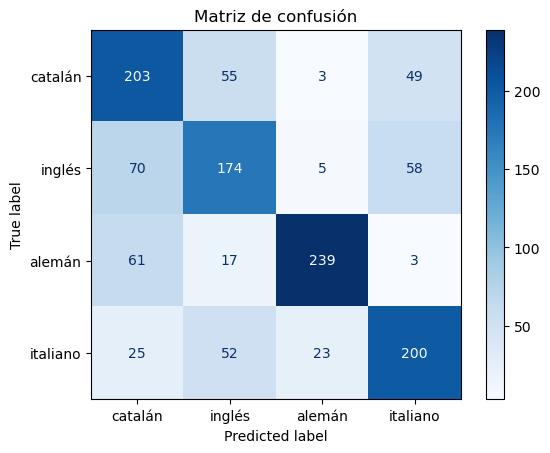

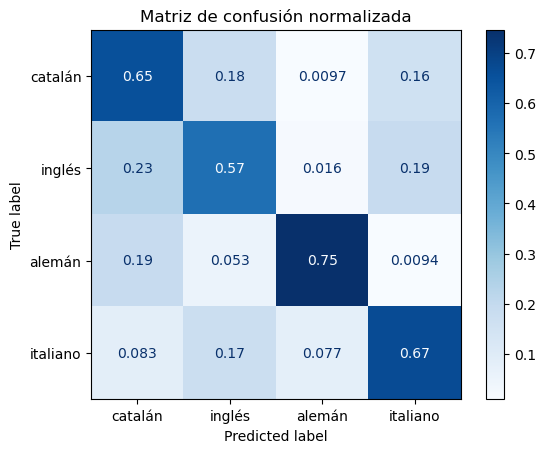

In [47]:
do_svm_kfolding(X,y)

In [48]:
# comenzar el vector de caracteristicas
X = []

for w in words:
    feature = []
    # aparición de caracteres especiales de un lenguaje
    for ch in char_per_one_language:
        if que_idioma(w, ch) > 0:
            feature.append(que_idioma(w, ch))
        else:
            feature.append(0)
    # aparición de sílabas especiales de un lenguaje
    for s in sil_per_one_language:
        if que_idioma(w, s) > 0:
            feature.append(que_idioma(w, s))
        else:
            feature.append(0)

    # añadir el vector de características
    X.append(feature)
    
# convertir a pandas para posible tratamiento
X = pd.DataFrame(X)

for i in range(len(y)):
    for j in range(len(languages)):
        if y[i] == languages[j]:
            y[i] = j

[0.38 0.4  0.41 0.39 0.41 0.37 0.38 0.37 0.37 0.39]
Ratio de aciertos en el bloque de predicción: 0.375909458367017
F1-Score: [0.19 0.27 0.42 0.44]
Precision: [1.   0.98 1.   0.28]
Recall: [0.1  0.16 0.27 1.  ]
Matriz de confusión
[[ 32   0   0 278]
 [  0  49   0 258]
 [  0   0  85 235]
 [  0   1   0 299]]
Matriz de confusión normalizada
[[0.1  0.   0.   0.9 ]
 [0.   0.16 0.   0.84]
 [0.   0.   0.27 0.73]
 [0.   0.   0.   1.  ]]


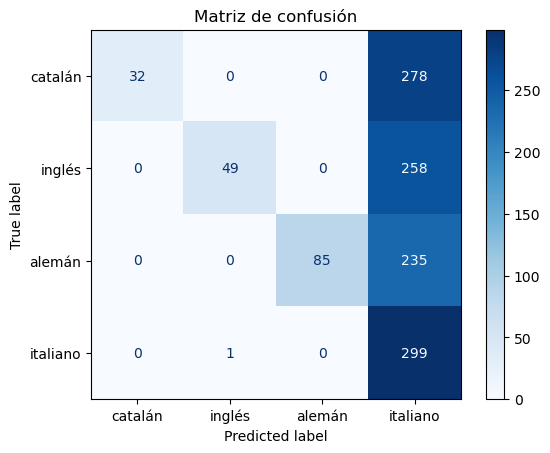

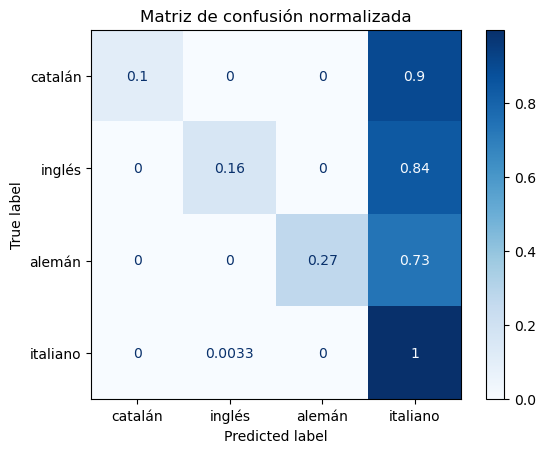

In [49]:
do_svm_kfolding(X,y)

In [50]:
X = []

for w in words:
    feature = []
    #conteo de los caracteres en las palabras
    for s in silabas:
        if len(s) == 1:
            feature.append(contar_caracter(w,s))
            
    # aparición de todas las sílabas
    # for s in silabas:
    #     if len(s) != 1:
    #         if w.find(s) != -1:
    #             feature.append(1)
    #         else:
    #             feature.append(0)
    
    # añadir el vector de características
    X.append(feature)

# convertir a pandas para posible tratamiento
X = pd.DataFrame(X)

for i in range(len(y)):
    for j in range(len(languages)):
        if y[i] == languages[j]:
            y[i] = j

[0.69 0.66 0.64 0.64 0.65 0.61 0.61 0.61 0.61 0.65]
Ratio de aciertos en el bloque de predicción: 0.6410670978172999
F1-Score: [0.6  0.55 0.81 0.62]
Precision: [0.56 0.54 0.87 0.62]
Recall: [0.64 0.56 0.75 0.61]
Matriz de confusión
[[198  61   6  45]
 [ 72 172   3  60]
 [ 58  17 240   5]
 [ 23  68  26 183]]
Matriz de confusión normalizada
[[0.64 0.2  0.02 0.15]
 [0.23 0.56 0.01 0.2 ]
 [0.18 0.05 0.75 0.02]
 [0.08 0.23 0.09 0.61]]


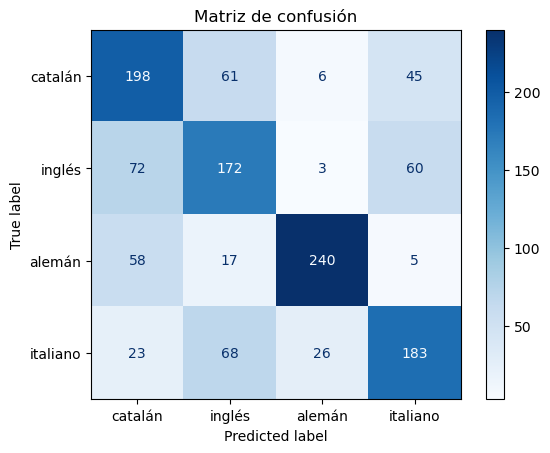

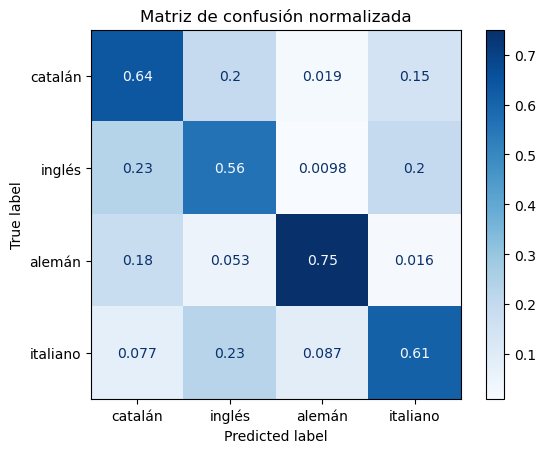

In [51]:
do_svm_kfolding(X,y)

In [52]:
X = []

for w in words:
    feature = []
    # código ascii del comienzo y final de las palabras
    feature.append(ord(w[0]))
    feature.append(ord(w[len(w)-1]))

    # longitud de la palabra
    feature.append(len(w))
    
    # añadir el vector de características
    X.append(feature)

# convertir a pandas para posible tratamiento
X = pd.DataFrame(X)

for i in range(len(y)):
    for j in range(len(languages)):
        if y[i] == languages[j]:
            y[i] = j

Podemos proceder a una primera prediccion del svm

[0.52 0.54 0.51 0.52 0.48 0.49 0.51 0.48 0.5  0.55]
Ratio de aciertos en el bloque de predicción: 0.5489086499595797
F1-Score: [0.56 0.41 0.69 0.52]
Precision: [0.45 0.53 0.87 0.52]
Recall: [0.76 0.34 0.57 0.53]
Matriz de confusión
[[236  18   0  56]
 [143 103   5  56]
 [ 66  36 181  37]
 [ 81  38  22 159]]
Matriz de confusión normalizada
[[0.76 0.06 0.   0.18]
 [0.47 0.34 0.02 0.18]
 [0.21 0.11 0.57 0.12]
 [0.27 0.13 0.07 0.53]]


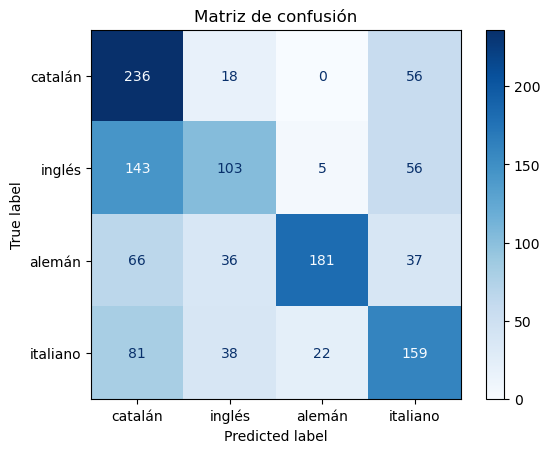

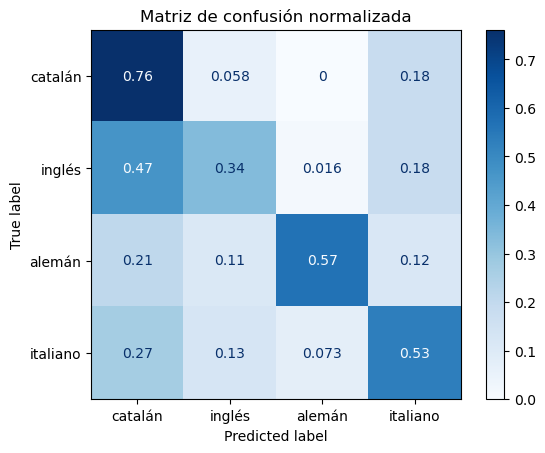

In [53]:
do_svm_kfolding(X,y)

In [54]:
X = []

for w in words:
    feature = []
    # ratio de consonantes y vocales
    # feature.append((contar_consonantes(w)+1)/(contar_vocales(w)+1))
    ### Makes it worse :( ###
    
    # densidad de las vocales
    # feature.append(contar_vocales(w)/len(w))
    ### Doesn't change a thing, same precision, same numbers ###
    
    # densidad de las consonantes
    feature.append(contar_consonantes(w)/len(w))

    # numero de vocales
    # feature.append(contar_vocales(w))
    ### Doesn't change a thing, same precision, same numbers ###

    # numero de consonantes
    feature.append(contar_consonantes(w))

    # añadir el vector de características
    X.append(feature)

# convertir a pandas para posible tratamiento
X = pd.DataFrame(X)

for i in range(len(y)):
    for j in range(len(languages)):
        if y[i] == languages[j]:
            y[i] = j

[0.38 0.44 0.41 0.39 0.4  0.4  0.45 0.42 0.42 0.41]
Ratio de aciertos en el bloque de predicción: 0.4316895715440582
F1-Score: [0.48 0.16 0.39 0.57]
Precision: [0.37 0.38 0.47 0.52]
Recall: [0.68 0.1  0.33 0.63]
Matriz de confusión
[[210  10  49  41]
 [143  30  54  80]
 [147  13 106  54]
 [ 71  26  15 188]]
Matriz de confusión normalizada
[[0.68 0.03 0.16 0.13]
 [0.47 0.1  0.18 0.26]
 [0.46 0.04 0.33 0.17]
 [0.24 0.09 0.05 0.63]]


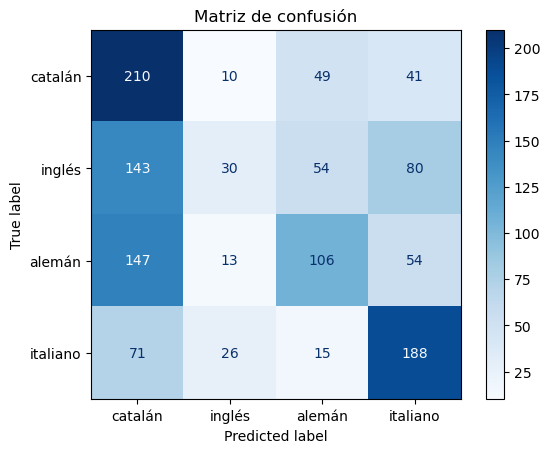

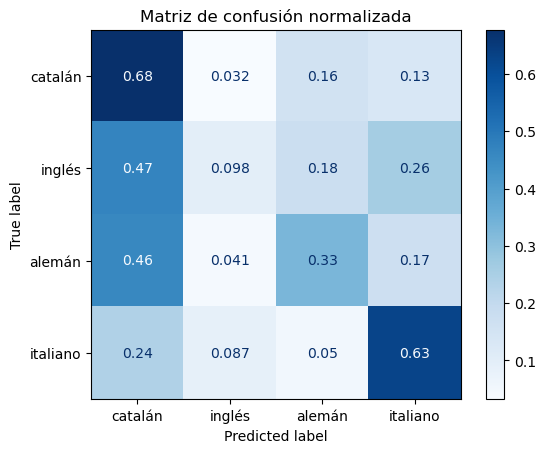

In [55]:
do_svm_kfolding(X,y)

In [56]:
X = []

for w in words:
    feature = []
    
    # aparición de sílabas especiales de un lenguaje
    for s in sil_per_one_language:
        if que_idioma(w, s) > 0:
            feature.append(que_idioma(w, s))
        else:
            feature.append(0)

    #conteo de los caracteres en las palabras
    for s in silabas:
        if len(s) == 1:
            feature.append(contar_caracter(w,s))

    # código ascii del comienzo y final de las palabras
    feature.append(ord(w[0]))
    feature.append(ord(w[len(w)-1]))

    # longitud de la palabra
    feature.append(len(w))

    # densidad de las consonantes
    feature.append(contar_consonantes(w)/len(w))

    # numero de consonantes
    feature.append(contar_consonantes(w))

    # añadir el vector de características
    X.append(feature)

# convertir a pandas para posible tratamiento
X = pd.DataFrame(X)
print(len(X.columns))
for i in range(len(y)):
    for j in range(len(languages)):
        if y[i] == languages[j]:
            y[i] = j

79


[0.7  0.68 0.67 0.66 0.65 0.62 0.61 0.62 0.63 0.68]
Ratio de aciertos en el bloque de predicción: 0.6596604688763137
F1-Score: [0.6  0.58 0.82 0.65]
Precision: [0.56 0.58 0.89 0.65]
Recall: [0.65 0.57 0.75 0.66]
Matriz de confusión
[[200  57   3  50]
 [ 71 176   3  57]
 [ 60  17 241   2]
 [ 24  54  23 199]]
Matriz de confusión normalizada
[[0.65 0.18 0.01 0.16]
 [0.23 0.57 0.01 0.19]
 [0.19 0.05 0.75 0.01]
 [0.08 0.18 0.08 0.66]]


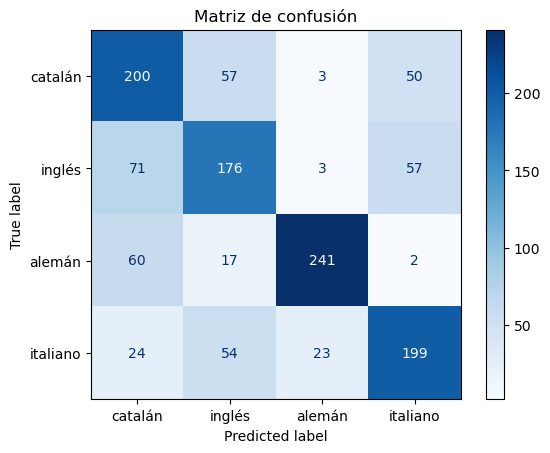

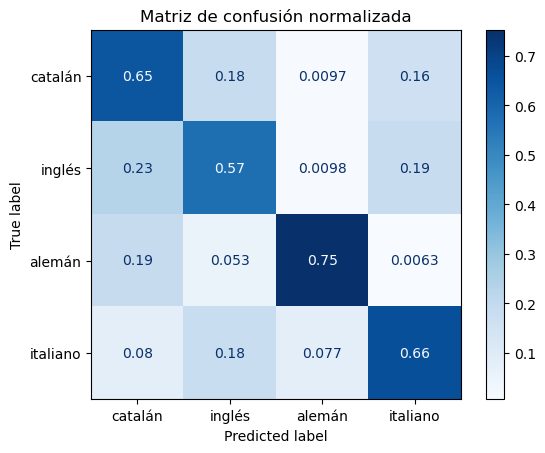

In [57]:
do_svm_kfolding(X,y)

In [58]:
do_svm_hyper_parameters(X,y)